In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dropout, Concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the datasets
!unzip /content/drive/MyDrive/Colab_data/salt_dataset/train.zip -d /content/data/

In [5]:
# Get list of images
img_path = '/content/data/images/'
list_img = os.listdir(img_path)
print('Number of images:', len(list_img))

# Get list of masks
mask_path = '/content/data/masks/'
list_mask = os.listdir(mask_path)

Number of images: 4000


In [6]:
# Set up X and y
X = np.zeros((len(list_img), 128, 128, 1), dtype=np.float32)
y = np.zeros((len(list_mask), 128, 128, 1), dtype=np.float32)

In [7]:
# Load images
for idx, filename in enumerate(list_img):
    img = load_img(img_path + filename, color_mode='grayscale', target_size=(128, 128, 1))
    x_img = img_to_array(img)
    X[idx] = x_img / 255.0

# Load masks
for idx, filename in enumerate(list_mask):
    mask = load_img(mask_path + filename, color_mode='grayscale', target_size=(128, 128, 1))
    y_mask = img_to_array(mask)
    # Divide by 65535.0 because y_mask is a 16-bit grayscale images and it only has white and black
    y[idx] = y_mask / 65535.0

In [8]:
# Split train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print('Size of training set:', y_train.shape[0])
print('Size of validation set:', y_val.shape[0])

Size of training set: 3200
Size of validation set: 800


Text(0.5, 1.0, 'Salt')

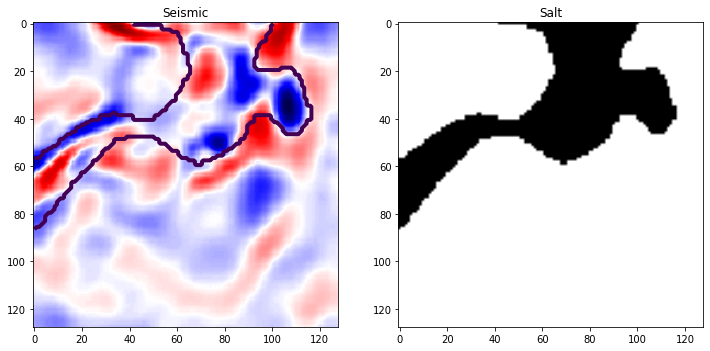

In [9]:
# Let's see the ground truth of random images
idx = random.randint(0, len(X_train))
has_mask = y_train[idx].max() > 0   # Salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# "X_train[idx, ..., 0]" is similar to "X_train[idx, :, :, 0]"
ax1.imshow(X_train[idx, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax1.contour(y_train[idx].squeeze(), linewidths=4, levels=[0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[idx].squeeze(), cmap='gray', interpolation='bilinear')
ax2.set_title('Salt')

**Create U-Net model**

In [10]:
def conv2d_blocks(input_tensor, filters):
    x1 = Conv2D(filters=filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(input_tensor)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters=filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    return x2

In [11]:
inputs = Input(shape=(128, 128, 1))

# Encoder
c1 = conv2d_blocks(inputs, 16)
p1 = MaxPooling2D(pool_size=(2, 2))(c1)

c2 = conv2d_blocks(p1, 32)
p2 = MaxPooling2D(pool_size=(2, 2))(c2)

c3 = conv2d_blocks(p2, 64)
p3 = MaxPooling2D(pool_size=(2, 2))(c3)

c4 = conv2d_blocks(p3, 128)
d4 = Dropout(0.5)(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(d4)

c5 = conv2d_blocks(p4, 256)
d5 = Dropout(0.5)(c5)

# Decoder
u6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(d5))
m6 = Concatenate()([d4, u6])
c6 = conv2d_blocks(m6, 128)

u7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(c6))
m7 = Concatenate()([c3, u7])
c7 = conv2d_blocks(m7, 64)

u8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(c7))
m8 = Concatenate()([c2, u8])
c8 = conv2d_blocks(m8, 32)

u9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(c8))
m9 = Concatenate()([c1, u9])
c9 = conv2d_blocks(m9, 16)

c10 = Conv2D(1, 1, padding='same', activation='sigmoid')(c9)

# Define model
model = Model(inputs=[inputs], outputs=[c10])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
es = EarlyStopping(patience=10, verbose=1)
rdlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5,
                         min_lr=0.00001, verbose=1, mode='max')

# Define callbacks
callbacks = [es, rdlr, checkpoint]

In [15]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1,
                 callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/50
100/100 [==============================] - 62s 116ms/step - loss: 0.4488 - accuracy: 0.8101 - val_loss: 2.9258 - val_accuracy: 0.2942

Epoch 00001: val_accuracy improved from -inf to 0.29416, saving model to best_model.h5
Epoch 2/50
100/100 [==============================] - 10s 101ms/step - loss: 0.3014 - accuracy: 0.8861 - val_loss: 1.2877 - val_accuracy: 0.6931

Epoch 00002: val_accuracy improved from 0.29416 to 0.69305, saving model to best_model.h5
Epoch 3/50
100/100 [==============================] - 11s 108ms/step - loss: 0.2913 - accuracy: 0.8897 - val_loss: 1.0600 - val_accuracy: 0.6860

Epoch 00003: val_accuracy did not improve from 0.69305
Epoch 4/50
100/100 [==============================] - 10s 102ms/step - loss: 0.2347 - accuracy: 0.9119 - val_loss: 0.4555 - val_accuracy: 0.8260

Epoch 00004: val_accuracy improved from 0.69305 to 0.82595, saving model to best_model.h5
Epoch 5/50
100/100 [==============================] - 10s 102ms/step - loss: 0.2319 - accuracy

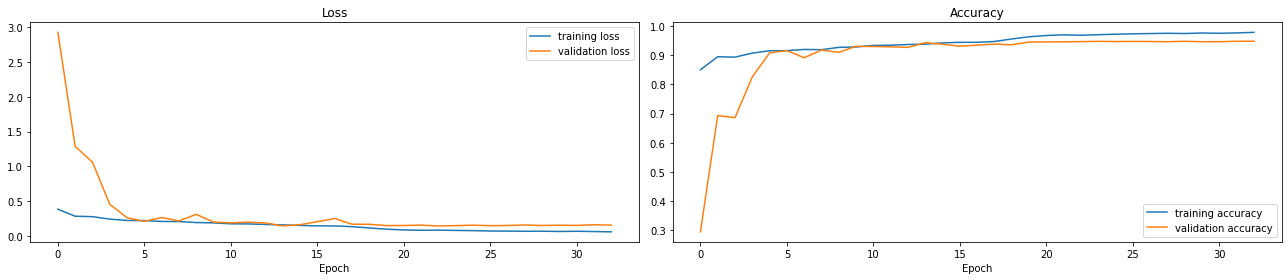

In [16]:
plt.figure(figsize=(18, 4))

plt.subplot(121)
plt.title('Loss')
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(122)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='training accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
best_model = load_model('best_model.h5')

In [18]:
preds_train = best_model.predict(X_train, verbose=1)
preds_val = best_model.predict(X_val, verbose=1)

25/25 [==============================] - 1s 30ms/step


In [19]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [40]:
def plot_sample(X, y, preds, binary_preds, n_rows, n_cols=4):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), squeeze=False)
    for row in range(0, n_rows):
        for col in range(0, n_cols):
            ix = col % n_cols
            if ix == 0:
                # Get random image index
                idx = random.randint(0, len(X))
                has_mask = y[idx].max() > 0

                ax[row][col].imshow(X[idx, ..., 0], cmap='seismic')
                if has_mask:
                    ax[row][col].contour(y[idx].squeeze(), levels=[0.5])
                ax[row][col].set_title('Seismic')

            elif ix == 1:
                ax[row][col].imshow(y[idx].squeeze())
                ax[row][col].set_title('Salt')

            elif ix == 2:   
                ax[row][col].imshow(preds[idx].squeeze(), vmin=0, vmax=1)
                if has_mask:
                    ax[row][col].contour(y[idx].squeeze(), colors='k', levels=[0.5])
                ax[row][col].set_title('Salt Predicted')

            else:   
                ax[row][col].imshow(binary_preds[idx].squeeze(), vmin=0, vmax=1)
                if has_mask:
                    ax[row][col].contour(y[idx].squeeze(), colors='k', levels=[0.5])
                ax[row][col].set_title('Salt Predicted binary')

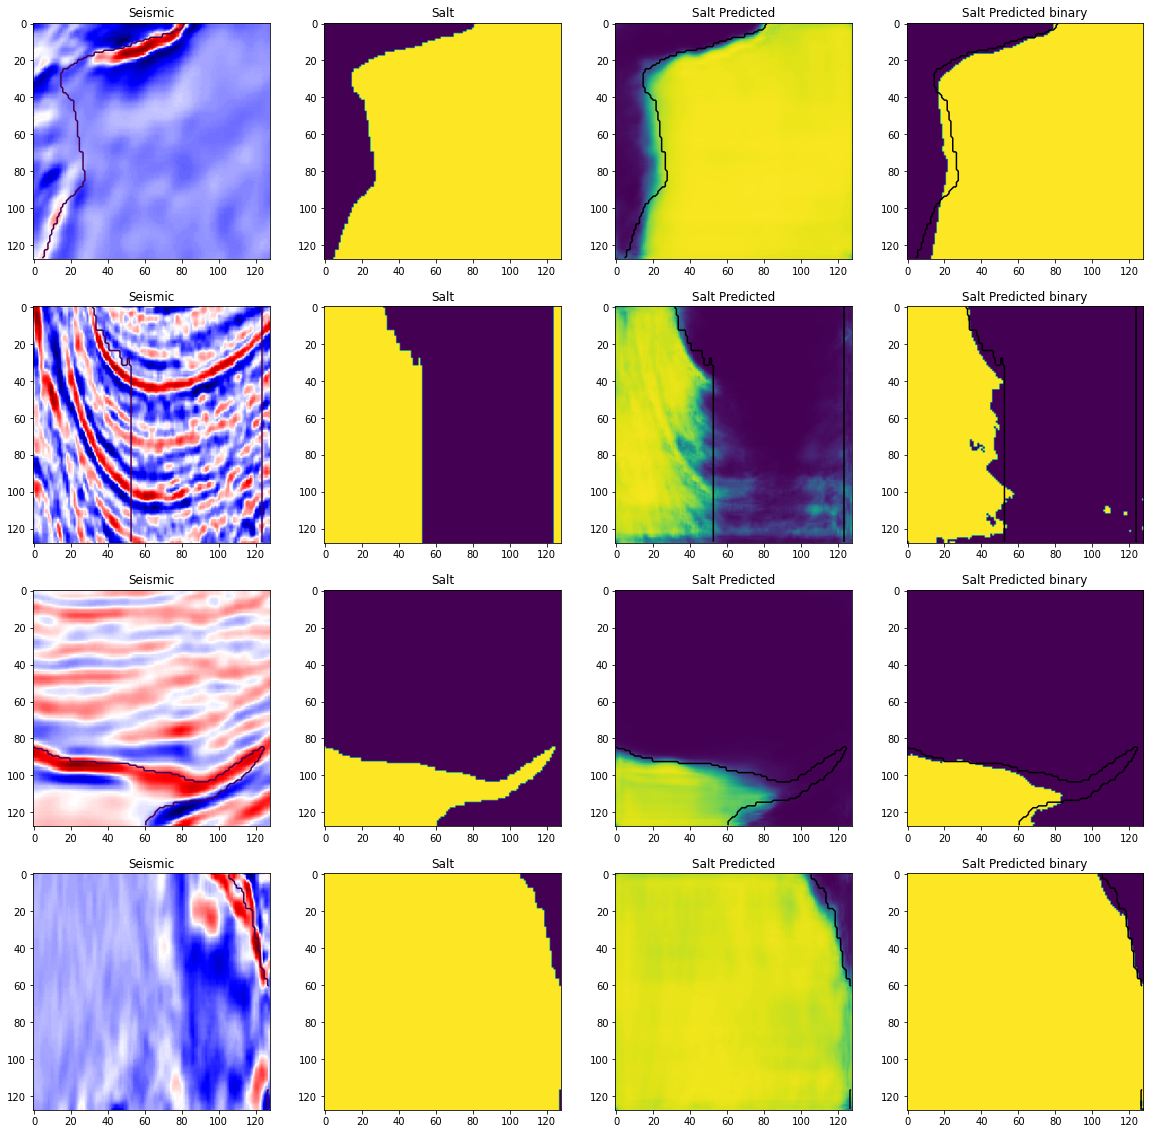

In [42]:
plot_sample(X_train, y_train, preds_train, preds_train_t, 4)